In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
local_zip = '/content/drive/MyDrive/University/Thesis/Thesis Project Folder/SkinDiseaseDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/tmp/SkinDiseaseDataset', output='/tmp/Dataset', ratio=(.6,.2,.2), group_prefix=None,seed=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 9655 files [00:05, 1763.50 files/s]


In [9]:
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

#Start
train_data_path = '/tmp/Dataset/train'
valid_data_path ='/tmp/Dataset/val'
test_data_path = '/tmp/Dataset/test'


In [5]:
#Hyperparameters
img_rows = 150
img_cols = 150
epochs = 10
batch_size = 32

In [6]:
#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle= True,
                                                    seed=42)

validation_generator = train_datagen.flow_from_directory(valid_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42)

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Found 5792 images belonging to 3 classes.
Found 1930 images belonging to 3 classes.
Found 1933 images belonging to 3 classes.


In [7]:
num_of_train_samples = 5792
num_of_valid_samples =1930
num_of_test_samples = 1933

In [10]:
# Build model
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_rows, img_cols, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
#Train
history=model.fit(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_valid_samples // batch_size)

Epoch 1/10
181/181 [==============================] - 55s 286ms/step - loss: 0.8359 - accuracy: 0.6001 - val_loss: 0.6110 - val_accuracy: 0.7365
Epoch 2/10
181/181 [==============================] - 47s 261ms/step - loss: 0.5955 - accuracy: 0.7619 - val_loss: 0.4631 - val_accuracy: 0.8229
Epoch 3/10
181/181 [==============================] - 48s 267ms/step - loss: 0.4971 - accuracy: 0.8078 - val_loss: 0.4431 - val_accuracy: 0.8323
Epoch 4/10
181/181 [==============================] - 48s 267ms/step - loss: 0.4549 - accuracy: 0.8203 - val_loss: 0.3905 - val_accuracy: 0.8469
Epoch 5/10
181/181 [==============================] - 48s 266ms/step - loss: 0.4321 - accuracy: 0.8348 - val_loss: 0.3725 - val_accuracy: 0.8417
Epoch 6/10
181/181 [==============================] - 48s 266ms/step - loss: 0.4155 - accuracy: 0.8391 - val_loss: 0.3589 - val_accuracy: 0.8594
Epoch 7/10
181/181 [==============================] - 47s 261ms/step - loss: 0.3954 - accuracy: 0.8496 - val_loss: 0.3609 - val_ac

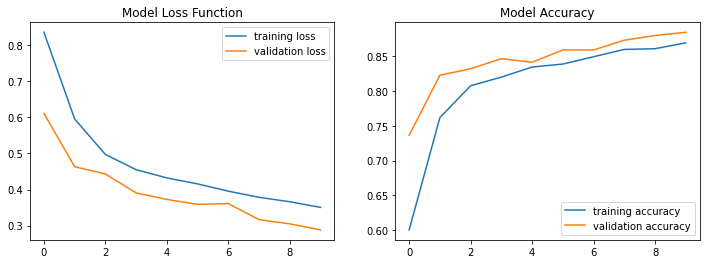

In [12]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

61/61 [==============================] - 4s 70ms/step


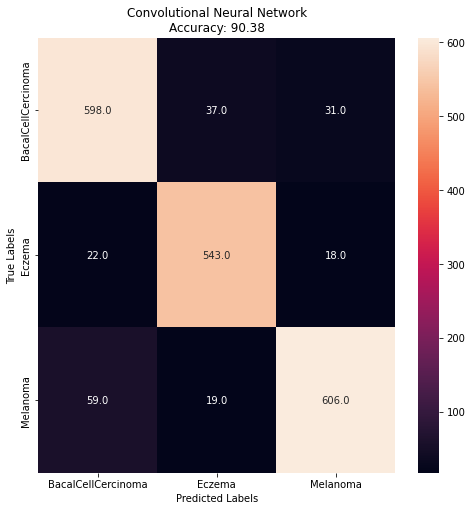

In [15]:
# Predicting labels from X_test data
y_pred = model.predict(test_generator)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(test_generator.classes, y_pred_classes)
cm_df = pd.DataFrame(confmx,
                     
                     index = ['BacalCellCercinoma' ,'Eczema' ,'Melanoma'], 
                     columns = ['BacalCellCercinoma' ,'Eczema' ,'Melanoma'])

f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(cm_df, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Convolutional Neural Network\nAccuracy: {0:.2f}'.format(accuracy_score(test_generator.classes, y_pred_classes)*100))
plt.show();

In [16]:
report = pd.DataFrame(classification_report(y_true = test_generator.classes, y_pred = y_pred_classes, output_dict=True)).transpose()
report = report.rename(index={'0': 'BacalCellCercinoma','1':'Eczema','2':'Melanoma'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
BacalCellCercinoma,88.07,89.79,88.92,666.000000
Eczema,90.65,93.14,91.88,583.000000
Melanoma,92.52,88.60,90.52,684.000000
accuracy,90.38,90.38,90.38,0.903777
macro avg,90.41,90.51,90.44,1933.000000
weighted avg,90.42,90.38,90.38,1933.000000
